# Image Translation

This will provide you an introduction image translation formulated as a regression problem using a U-Net model.
Hopefully you will be acqainted with the U-Net model by now. At its core, it's an autoencoder, consisting of an encoder (downsampling) part and a decoder (upsampling) part. The U-Net model has become immensely popular in many image analysis tasks, and one of its main strengths are the skip connections between the encoder and decoder layers which allows the model to capture details at and near the input level resolution. If you've seen U-Nets being used for image segmentation previously, you only need minor adjustments to adapt it to image regression, by changing the loss function and the final activation layer (more on that later).

Below is an overview of the 2D U-Net model architecture as in the original paper (figure courtesy of [Uni Freiburg](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)). We'll be using a very similar architecture but with same padding, which means the input image and the output image will have the same shape.

![U-Net architecture](u-net-architecture.png)

Let's start with some imports. We'll be using the open source U-Net repository [microDL](https://github.com/czbiohub/microDL) , so we'll import that along with some plotting and other utility packages.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import importlib
import os
import pandas as pd
import pprint
import sys

import micro_dl.cli.image_inference as inference
# import micro_dl.cli.metrics_script as metrics
import micro_dl.cli.train_script as train
import micro_dl.cli.preprocess_script as preprocess
import micro_dl.utils.aux_utils as aux_utils
import micro_dl.utils.image_utils as im_utils
import micro_dl.utils.masks as mask_utils
import micro_dl.utils.normalize as norm_utils
import micro_dl.utils.train_utils as train_utils

# Add module path to sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Setup pretty print
pp = pprint.PrettyPrinter(indent=4)

Using TensorFlow backend.


/home/paperspace/Code/microDL


In [2]:
# First of all we'll define some paths we'll be reading data from and saving to
# This is the directory where our imaging data is downloaded
INPUT_DIR = '/home/paperspace/Data/MBL_DL_image_translation/data/'
# And specify where we want to store our preprocessed data
PREPROC_OUTPUT_DIR = '/home/paperspace/Data/translation_preprocessed_data/'
# This is where the model weights and related variables will be stored
MODEL_DIR = '/home/paperspace/Data/translation_model_adam_mae'

## Preprocessing

In microDL we'll be using three main modules, preprocessing, training and inference (see imports above). 
The first step is the preprocessing. We have some options like resizing, flatfield correction, creating masks, and tiling.
The data we're working with is already background corrected so we can safely skip that part. We also don't need to resize the images.

We would however like to create masks based on our target data. The reason for that is that we would like to avoid training on background only, that is empty or near empty tiles. A threshold we found reasonable is to make sure that our tiles contain 25% signal or more.

We would also like to tile our images. The original image size (2048 x 2048 pixels) which is by far too large to be able to fit into memory, and there's repeating structures occurring across the images so we'd be much better of splitting the images into smalles pieces (tiles). A design consideration for convolution neural networks is the [receptive field](https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807), which is the region of the input space a given feature is looking at. Given the size of our structures of interest and our network architecture, we use 256 x 256 pixel tiles.

Usually we run microDL through command line interfaces (CLIs), which is to say we just input commands in the terminal. For each module we specify the path to a config file as a command line argument. Since we're using Jupyter Notebook for this tutorial we will instead load the preprocessing config so we can take a look at it.

In [3]:
config_path = os.path.join(
    module_path,
    'micro_dl/config_preprocess.yml',
)
preproc_config = aux_utils.read_config(config_path)
pp.pprint(preproc_config)

{   'channel_ids': [0, 1, 2],
    'flat_field': {'estimate': True},
    'input_dir': '/Users/jenny.folkesson/Data/SMS-2018-07-03-18-35-00-0010',
    'masks': {   'channels': [1],
                 'mask_ext': 'png',
                 'mask_type': 'otsu',
                 'str_elem_radius': 3},
    'num_workers': 4,
    'output_dir': '/Users/jenny.folkesson/Data/SMS-2018-07-03-18-35-00-0010_train_data',
    'pos_ids': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'resize': {'resize_3d': False, 'scale_factor': 2},
    'slice_ids': [10, 11, 12, 13, 14, 15],
    'tile': {   'depths': [1, 1, 1],
                'image_format': 'zyx',
                'mask_depth': 1,
                'min_fraction': 0.25,
                'save_tiled_masks': True,
                'step_size': [128, 128],
                'tile_size': [256, 256]},
    'verbose': 10}


### Masks

We would like to generate binary masks based on our target channel. Let's for now assume our target channel is channel index = 2. In microDL we have two types of global binary thresholding methods builtin, [Otsu](https://en.wikipedia.org/wiki/Otsu%27s_method) and [unimodal](https://users.cs.cf.ac.uk/Paul.Rosin/resources/papers/unimodal2.pdf) (or Rosin) thresholding.
Let's load an image, generate masks and plot them side by side.

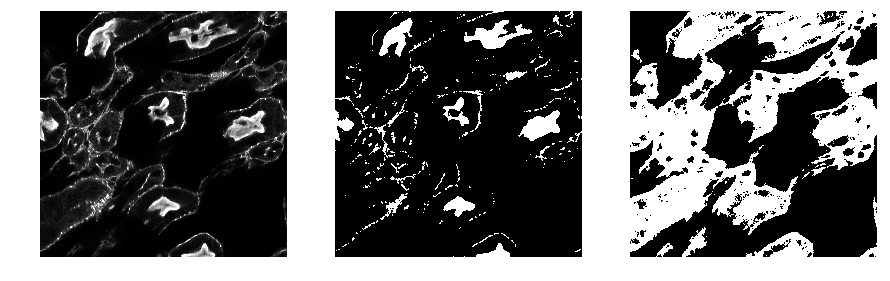

In [5]:
# Load image
im_path = os.path.join(INPUT_DIR, 'img_568_t000_p003_z010.tif')
im = im_utils.read_image(im_path)
# Clip top and bottom 1% of histogram for better visualization
im = norm_utils.hist_clipping(im, 1, 99)

mask_otsu = mask_utils.create_otsu_mask(im)
mask_rosin = mask_utils.create_unimodal_mask(im)

plt.subplot(131); plt.imshow(im, cmap='gray'); plt.axis('off')
plt.subplot(132); plt.imshow(mask_otsu, cmap='gray'); plt.axis('off')
plt.subplot(133); plt.imshow(mask_rosin, cmap='gray'); plt.axis('off')
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

As you can see, the Otsu threshold captures only the very bright structures and misses dim structures. Rosin thresholding does a better job at these dim structures, so we'll be using Rosin thresholding for the analysis.

In [6]:
# There are some things we need to change around here. We're not doing resizing so let's remove that key
if 'resize' in preproc_config:
    preproc_config.pop('resize')
# We're not doing flatfield correction either
if 'flat_field' in preproc_config:
    preproc_config.pop('flat_field')
    
# We need to change input_dir to point to where our image data is located
preproc_config['input_dir'] = INPUT_DIR
# And where we want to store our preprocessed data
preproc_config['output_dir'] = PREPROC_OUTPUT_DIR

# Switch to unimodal (Rosin) thresholding
preproc_config['masks']['mask_type'] = 'unimodal'

# Our VMs have 8 cores so adjust the number of workers
preproc_config['num_workers'] = 8
# Let's look again
pp.pprint(preproc_config)

{   'channel_ids': [0, 1, 2],
    'input_dir': '/home/paperspace/Data/MBL_DL_image_translation/data/',
    'masks': {   'channels': [1],
                 'mask_ext': 'png',
                 'mask_type': 'unimodal',
                 'str_elem_radius': 3},
    'num_workers': 8,
    'output_dir': '/home/paperspace/Data/translation_preprocessed_data/',
    'pos_ids': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'slice_ids': [10, 11, 12, 13, 14, 15],
    'tile': {   'depths': [1, 1, 1],
                'image_format': 'zyx',
                'mask_depth': 1,
                'min_fraction': 0.25,
                'save_tiled_masks': True,
                'step_size': [128, 128],
                'tile_size': [256, 256]},
    'verbose': 10}


In [7]:
# Now let's break apart our config and also set some other parameters
# Typically microscopy images are indexed along channels, time, FOV (position) and slice (z)
# index of -1 mean include all indices
slice_ids = -1
if 'slice_ids' in preproc_config:
    slice_ids = preproc_config['slice_ids']
time_ids = -1
if 'time_ids' in preproc_config:
    time_ids = preproc_config['time_ids']
pos_ids = -1
if 'pos_ids' in preproc_config:
    pos_ids = preproc_config['pos_ids']
channel_ids = -1
if 'channel_ids' in preproc_config:
    channel_ids = preproc_config['channel_ids']
# The images are uniform in size
uniform_struct = True
# How many chars an index should be encoded as
int2str_len = 3
# Number of processes to use
num_workers = 4
if 'num_workers' in preproc_config:
    num_workers = preproc_config['num_workers']

base_config = {'input_dir': INPUT_DIR,
               'output_dir': PREPROC_OUTPUT_DIR,
               'slice_ids': slice_ids,
               'time_ids': time_ids,
               'pos_ids': pos_ids,
               'channel_ids': channel_ids,
               'uniform_struct': uniform_struct,
               'int2strlen': int2str_len,
               'num_workers': num_workers}

# Let's look at the base_config we just generated
pp.pprint(base_config)

{   'channel_ids': [0, 1, 2],
    'input_dir': '/home/paperspace/Data/MBL_DL_image_translation/data/',
    'int2strlen': 3,
    'num_workers': 8,
    'output_dir': '/home/paperspace/Data/translation_preprocessed_data/',
    'pos_ids': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'slice_ids': [10, 11, 12, 13, 14, 15],
    'time_ids': -1,
    'uniform_struct': True}


In [8]:
# Now it's time to do run the preprocessing
preproc_config, runtime = preprocess.pre_process(preproc_config, base_config)
print("Preprocessing took {} seconds".format(runtime))
# Save the final config and run time
preprocess.save_config(preproc_config, runtime)

Preprocessing took 42.82850790023804 seconds


You can navigate to your output_dir and take a look at what was generated. You will find a mask_dir containing masks, a tile_dir containing tiles and JSON file containing the all the information that was used to generated the preprocessed data. Let's take a look at a few tiles.

/home/paperspace/Data/translation_preprocessed_data/tiles_256-256_step_128-128
[14972 21815  5617 22808 28445]
im_c002_z010_t000_p004_r128-384_c1408-1664_sl0-1.npy im shape (1, 256, 256)
im_c002_z015_t000_p010_r1024-1280_c128-384_sl0-1.npy im shape (1, 256, 256)
im_c000_z014_t000_p009_r384-640_c1664-1920_sl0-1.npy im shape (1, 256, 256)
im_c003_z010_t000_p008_r512-768_c1280-1536_sl0-1.npy im shape (1, 256, 256)
im_c003_z015_t000_p004_r1024-1280_c1408-1664_sl0-1.npy im shape (1, 256, 256)


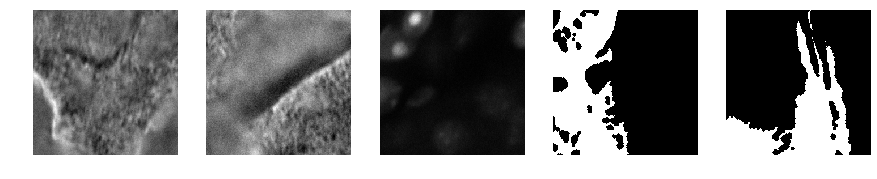

In [9]:
tile_dir = preproc_config['tile']['tile_dir']
print(tile_dir)
frames_meta = pd.read_csv(os.path.join(tile_dir, 'frames_meta.csv'))
# Randomly select 5 tiles and plot them
subset = np.random.choice(frames_meta.shape[0], 5, replace=False)
print(subset)
for i in range(5):
    im = im_utils.read_image(os.path.join(tile_dir, frames_meta.loc[subset[i], 'file_name']))
    print(frames_meta.loc[subset[i], 'file_name'], 'im shape', im.shape)
    plt.subplot(1, 5, i + 1); plt.imshow(np.squeeze(im), cmap='gray'); plt.axis('off')
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

## Training

Now that we've preprocessed our data we're ready to train. We would like to use brightfield, which is a label free channel, to predict two different fluorescent channels, actin and nuclei.
In our dataset, the channel names and indices are the following:

* Brightfield: channel name Transmission, index 2
* Actin:channel name 568, index 1
* Nuclei: channel name 405, index 0

Let's take a look at an image from each of these channels.

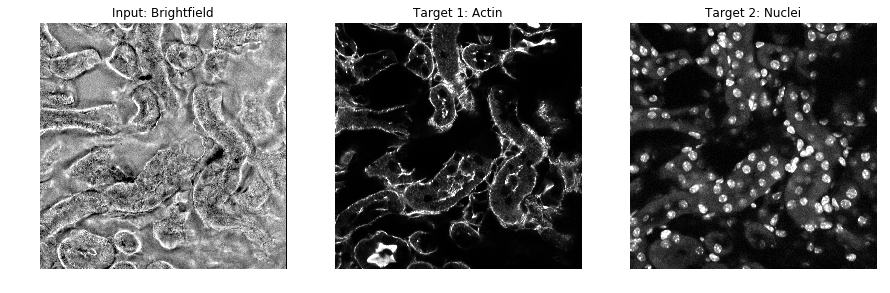

In [9]:
# Brightfield
im_path = os.path.join(INPUT_DIR, 'img_Transmission_t000_p010_z010.tif')
im = im_utils.read_image(im_path)
im = norm_utils.hist_clipping(im, 1, 99)
plt.subplot(131); plt.imshow(im, cmap='gray'); plt.title('Input: Brightfield'); plt.axis('off')
im_path = os.path.join(INPUT_DIR, 'img_568_t000_p010_z010.tif')
im = im_utils.read_image(im_path)
im = norm_utils.hist_clipping(im, 1, 99)
plt.subplot(132); plt.imshow(im, cmap='gray'); plt.title('Target 1: Actin'); plt.axis('off')
im_path = os.path.join(INPUT_DIR, 'img_405_t000_p010_z010.tif')
im = im_utils.read_image(im_path)
im = norm_utils.hist_clipping(im, 1, 99)
plt.subplot(133); plt.imshow(im, cmap='gray'); plt.title('Target 2: Nuclei'); plt.axis('off')
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [3]:
# Let's load a base 2D training config file and take a look
config_path = os.path.join(
    module_path,
    'micro_dl/config.yml',
)
train_config = aux_utils.read_config(config_path)
pp.pprint(train_config)

{   'dataset': {   'data_dir': '/data/anitha/label_free/image_tile_256-256_step_256-256',
                   'height': 256,
                   'input_channels': [3],
                   'split_by_column': 'pos_idx',
                   'split_ratio': {'test': 0.15, 'train': 0.7, 'val': 0.15},
                   'target_channels': [0],
                   'width': 256},
    'network': {   'activation': {'type': 'relu'},
                   'batch_norm': True,
                   'block_sequence': 'conv-activation-bn',
                   'class': 'UNet2D',
                   'data_format': 'channels_first',
                   'depth': 1,
                   'dropout': 0.2,
                   'dropout_dense': 0.4,
                   'filter_size': 3,
                   'final_activation': 'linear',
                   'height': 256,
                   'num_convs_per_block': 2,
                   'num_filters_per_block': [8, 16, 32, 64, 128],
                   'num_input_channels': 1,
          

There's a lot more options here, as you can see. The first things to check for when doing image translation is that the final activation is linear. Unlike for binary segmentation when we want to use a sigmoid to move values towards either zero or one, we would here like to do a regression and not apply any transform to our output signal.

There are some variables that it would be interesting for you to explore while training:

### Loss
The second thing is to choose a loss function that makes sense. Common choices for regression are the mean squared error (MSE) and the mean absolute error (MAE) between the target image y and the estimated image y':
\begin{equation*}
MSE = \sum_{p} (y_p - y_p')^2,
\end{equation*}

\begin{equation*}
MAE = \sum_{p} |y_p - y_p'|
\end{equation*}
for each pixel index p.

You can try both by changing train_config['trainer']['loss']. The names in microDL for losses are mse_loss and mae_loss, respectively. You can also try other custom losses by using the loss function names [here](https://github.com/czbiohub/microDL/blob/master/micro_dl/train/losses.py), or any standard [Keras loss function](https://keras.io/losses/) by specifying the loss function name defined by Keras. 

### Optimizer
A good default choice of optimizer is Adam. You can read more about different deep learning optimizers [here](http://ruder.io/optimizing-gradient-descent/), and you can change the optimizer you'd like to use in your training by changing the variable train_config['trainer']['optimizer']['name'] to any of the Keras optimizers listed [here](https://keras.io/optimizers/).

### Learning Rate
If the learning rate is too small your training might take a very long time to converge, and if it's too big it might not converge at all. It's worth trying some different values and see what happens with convergence.

### Dropout
Since we're working with a very small dataset in exploratory training, chances are that your network will overfit to your training data. It's worth exploring train_config['network']['dropout'] and train_config['network']['dropout_dense'] to see if increasing those variables can reduce overfitting.

### Other?
If you have extra time or are curious about the other variables, feel free to explore.

In [4]:
# For our training config, we need to make some initial adjustments
# Set the data directory to the directory we generated during preprocessing
train_config['dataset']['data_dir'] = PREPROC_OUTPUT_DIR
# We also need to specify where we want to store our model and all related data generated by training
# This directory will be created if it doesn't already exist
train_config['trainer']['model_dir'] = MODEL_DIR

In [5]:
# Time to train. First, let see what GPU resources are available
gpu_id, gpu_mem_frac = train_utils.select_gpu()
print("GPU {} has {:.2f} fraction of memory available".format(gpu_id, gpu_mem_frac))

Using GPU 0 with memory fraction 0.9599703205000343.
GPU 0 has 0.96 fraction of memory available


In [6]:
train.run_action(
    action='train',
    config=train_config,
    gpu_ids=gpu_id,
    gpu_mem_frac=gpu_mem_frac,
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model compiled
Steps per epoch: 178


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 256, 256)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 256, 256)  80          input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 8, 256, 256)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 8, 256, 256)  32          activation_1[0][0]               
__________________________________________________________________________________________________
dropout_1 

Epoch 1/10
178/178 [==============================] - 65s 363ms/step - loss: 0.9150 - pearson_corr: 0.1116 - val_loss: 0.6407 - val_pearson_corr: 0.3161

Epoch 00001: val_loss improved from inf to 0.64071, saving model to /home/paperspace/Data/translation_model_adam_mae/Model_2019-05-03-17-30-25.hdf5
Epoch 2/10
178/178 [==============================] - 57s 321ms/step - loss: 0.6138 - pearson_corr: 0.2151 - val_loss: 0.6297 - val_pearson_corr: 0.3166

Epoch 00002: val_loss improved from 0.64071 to 0.62967, saving model to /home/paperspace/Data/translation_model_adam_mae/Model_2019-05-03-17-30-25.hdf5
Epoch 3/10
178/178 [==============================] - 57s 321ms/step - loss: 0.5818 - pearson_corr: 0.2496 - val_loss: 0.6235 - val_pearson_corr: 0.2851

Epoch 00003: val_loss improved from 0.62967 to 0.62349, saving model to /home/paperspace/Data/translation_model_adam_mae/Model_2019-05-03-17-30-25.hdf5
Epoch 4/10
178/178 [==============================] - 57s 321ms/step - loss: 0.5701 - 

Training time: 248.07021832466125



Epoch 00004: val_loss did not improve from 0.62349
Epoch 00004: early stopping


We've completed our first training. Let's take a look at what happened during training by opening a history log file.

In [7]:
history = pd.read_csv(os.path.join(MODEL_DIR, 'history.csv'))
history.head()

,epoch,loss,pearson_corr,val_loss,val_pearson_corr
0,0,0.915283,0.111565,0.640705,0.316085
1,1,0.613768,0.215088,0.629669,0.316617
2,2,0.581777,0.249523,0.623494,0.285117
3,3,0.570115,0.278582,0.671415,0.246226


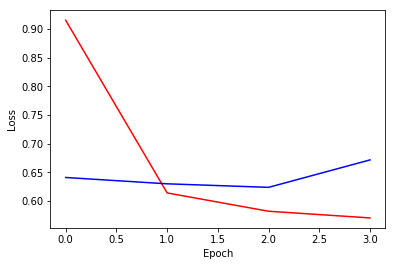

In [9]:
# Plot training vs. validation loss
plt.plot(history.epoch, history.loss, 'r')
plt.plot(history.epoch, history.val_loss, 'b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

To be able to view a p